  0%|          | 0/500 [00:00<?, ?it/s]

Epoch    0 | loss 1.3610e+00


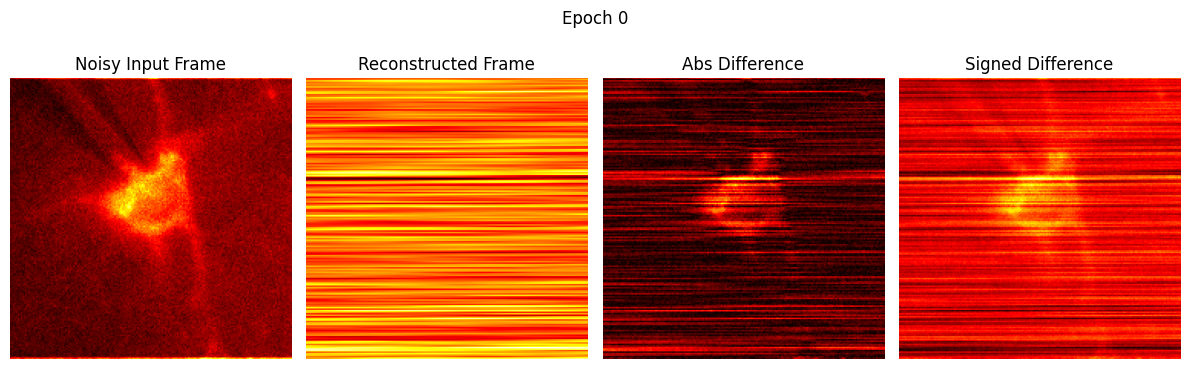

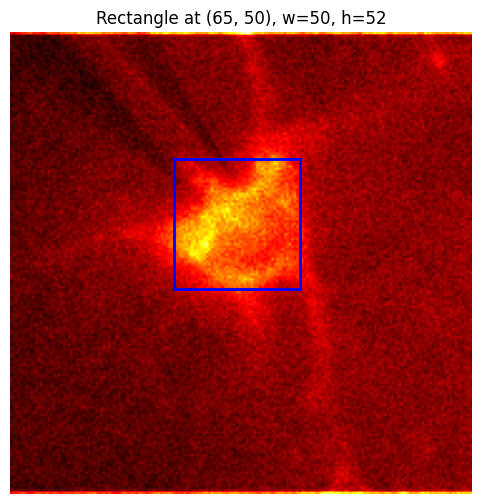

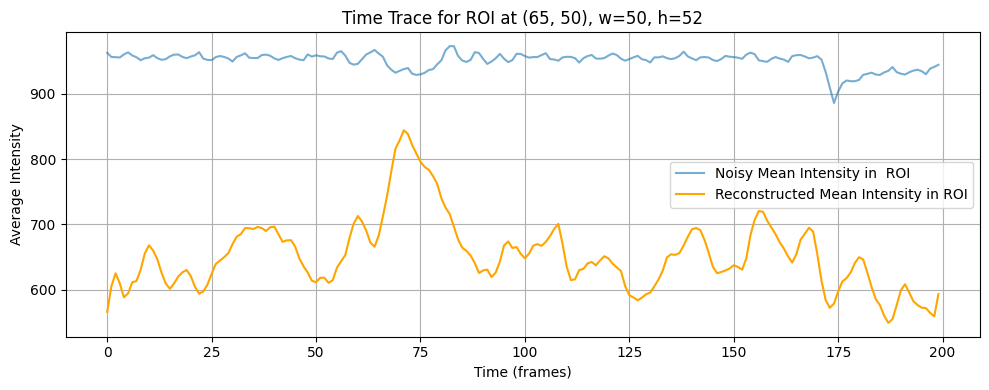

Epoch   10 | loss 4.2435e-01
Epoch   20 | loss 3.3630e-01
Epoch   30 | loss 3.3074e-01
Epoch   40 | loss 2.9960e-01
Epoch   50 | loss 2.4793e-01
Epoch   60 | loss 1.9581e-01
Epoch   70 | loss 1.8424e-01
Epoch   80 | loss 1.4777e-01
Epoch   90 | loss 1.1388e-01
Epoch  100 | loss 9.0829e-02


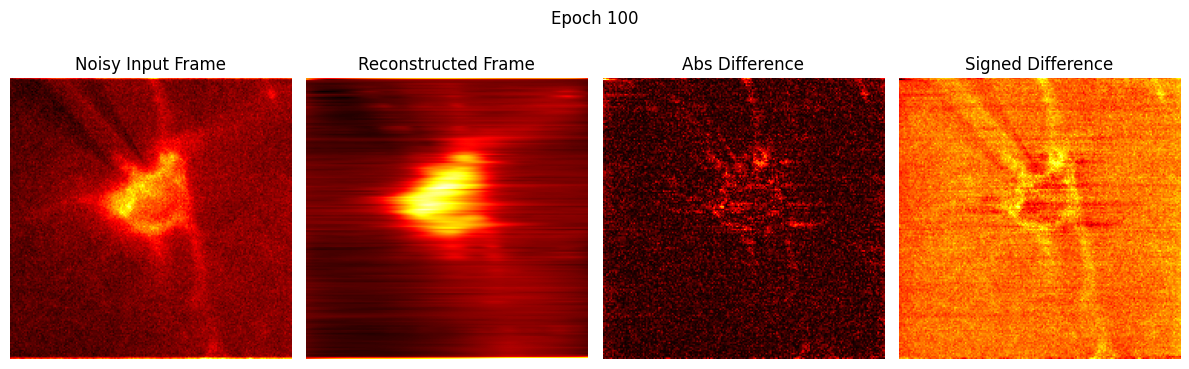

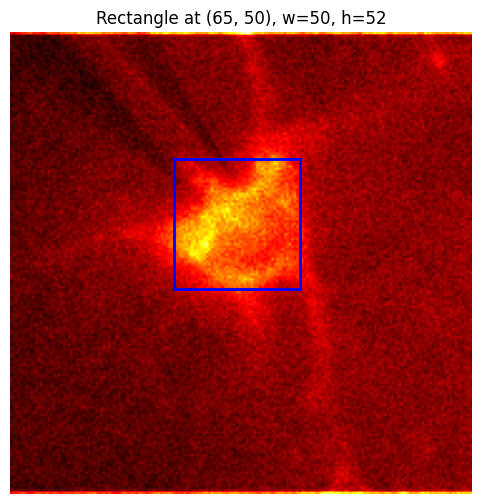

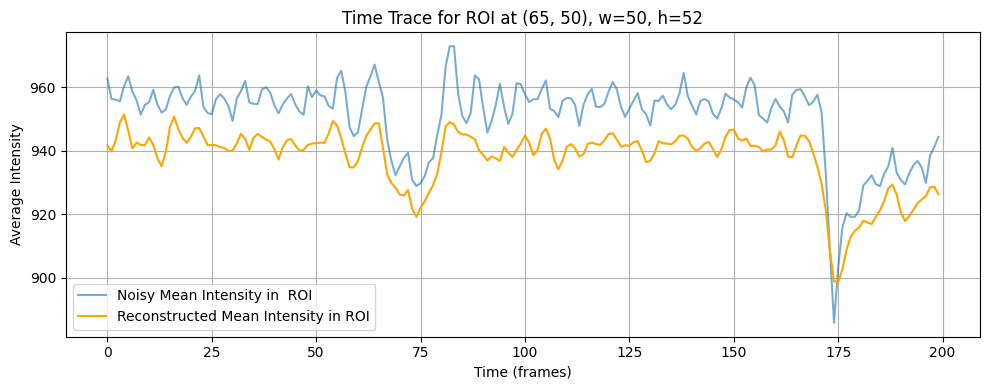

Epoch  110 | loss 1.0168e-01
Epoch  120 | loss 7.7225e-02
Epoch  130 | loss 1.0353e-01
Epoch  140 | loss 7.2767e-02
Epoch  150 | loss 6.2576e-02
Epoch  160 | loss 5.8893e-02
Epoch  170 | loss 6.1823e-02
Epoch  180 | loss 5.8884e-02
Epoch  190 | loss 5.6009e-02
Epoch  200 | loss 6.2470e-02


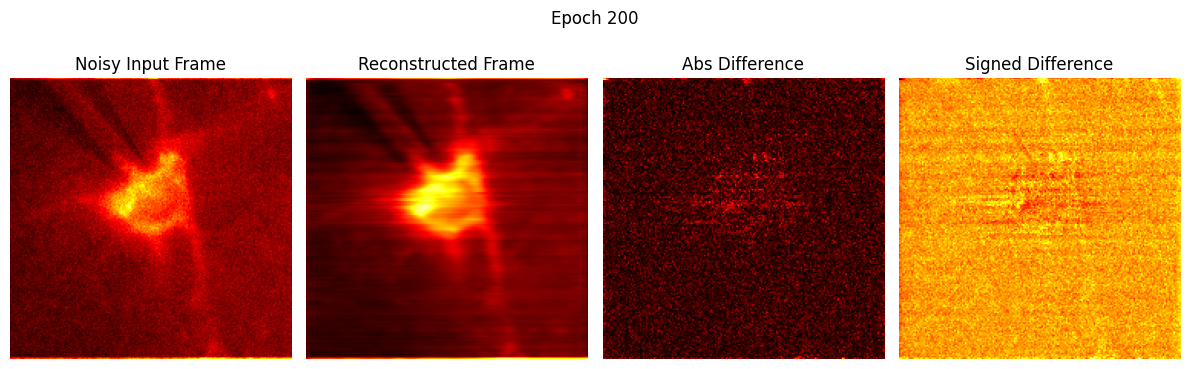

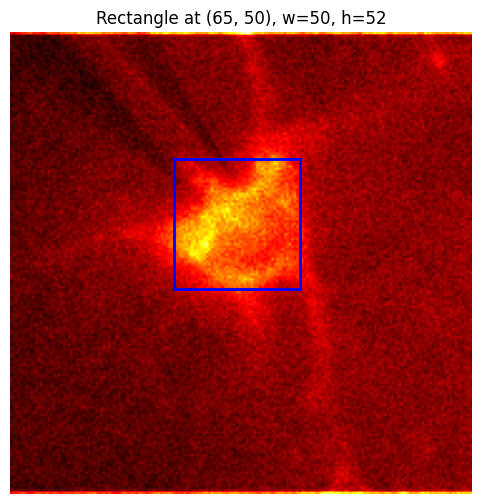

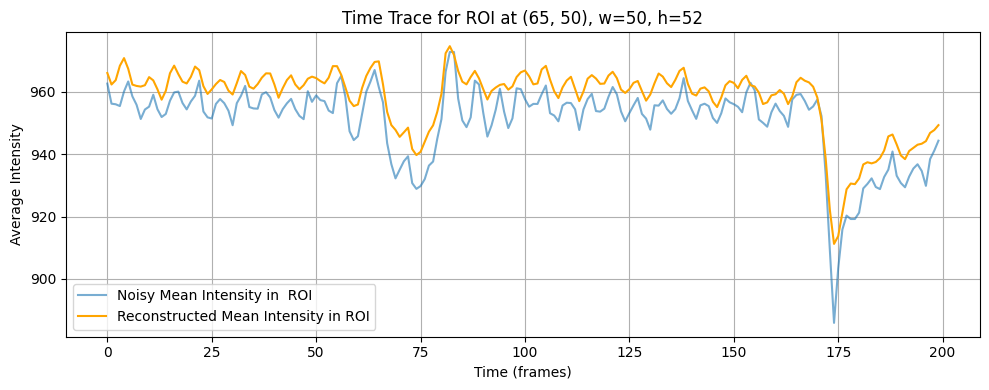

Epoch  210 | loss 5.6924e-02
Epoch  220 | loss 5.4571e-02
Epoch  230 | loss 5.3264e-02
Epoch  240 | loss 5.2503e-02
Epoch  250 | loss 5.2067e-02
Epoch  260 | loss 5.3280e-02
Epoch  270 | loss 5.2584e-02
Epoch  280 | loss 5.1894e-02
Epoch  290 | loss 5.1392e-02
Epoch  300 | loss 5.1198e-02


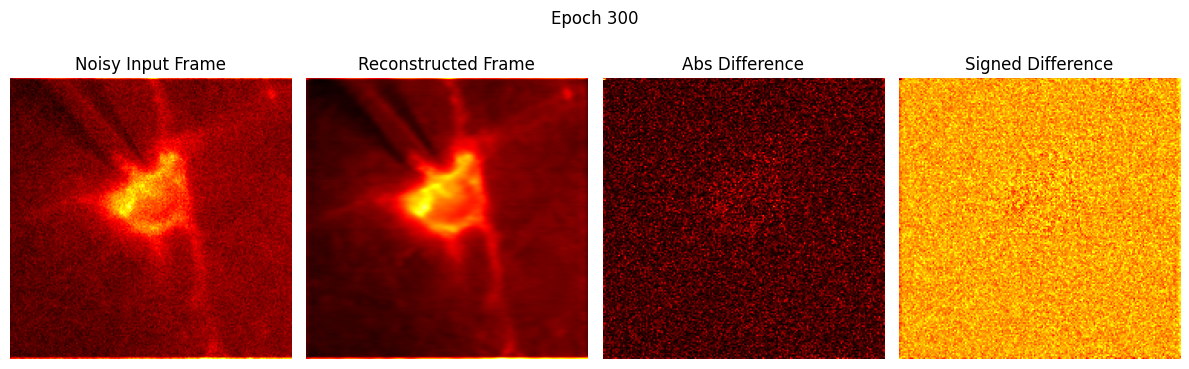

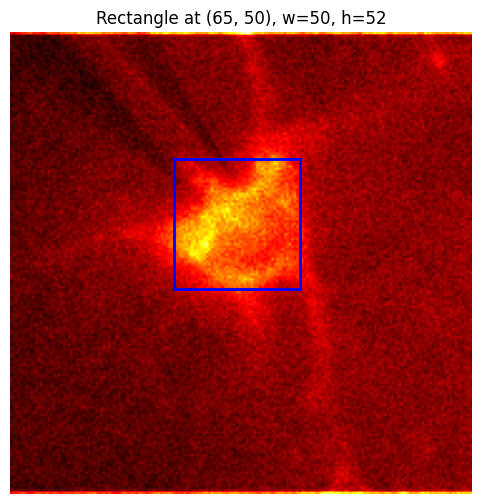

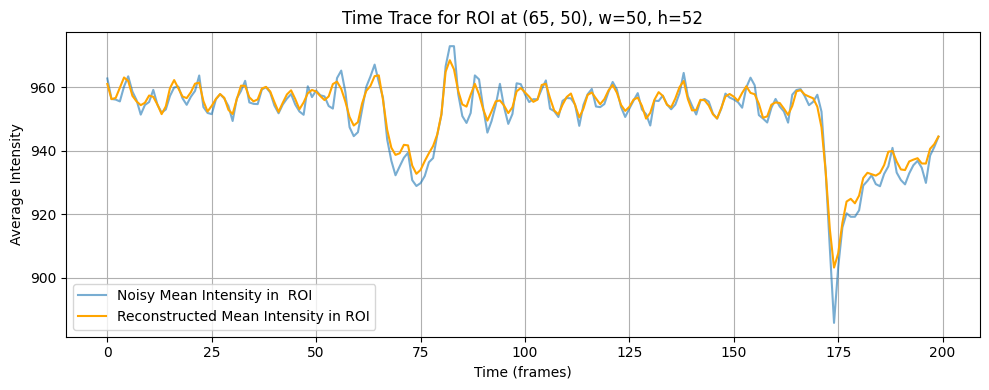

Epoch  310 | loss 5.1089e-02
Epoch  320 | loss 5.1641e-02
Epoch  330 | loss 5.1289e-02
Epoch  340 | loss 5.0934e-02
Epoch  350 | loss 5.0611e-02
Epoch  360 | loss 5.0462e-02
Epoch  370 | loss 5.0370e-02
Epoch  380 | loss 5.4695e-02
Epoch  390 | loss 5.2190e-02
Epoch  400 | loss 5.0702e-02


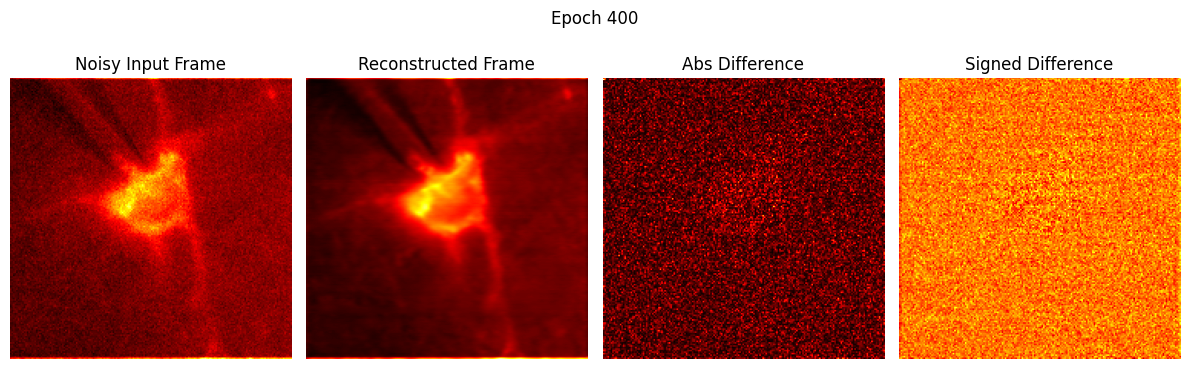

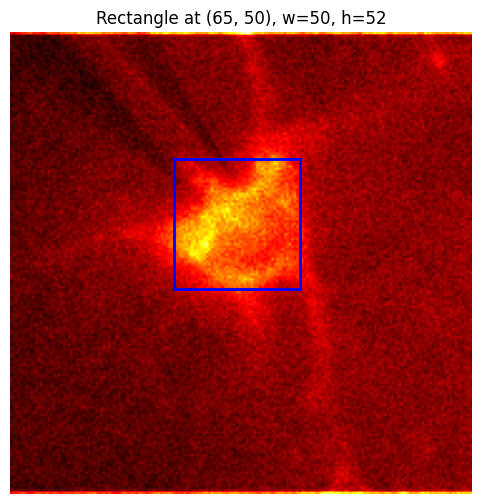

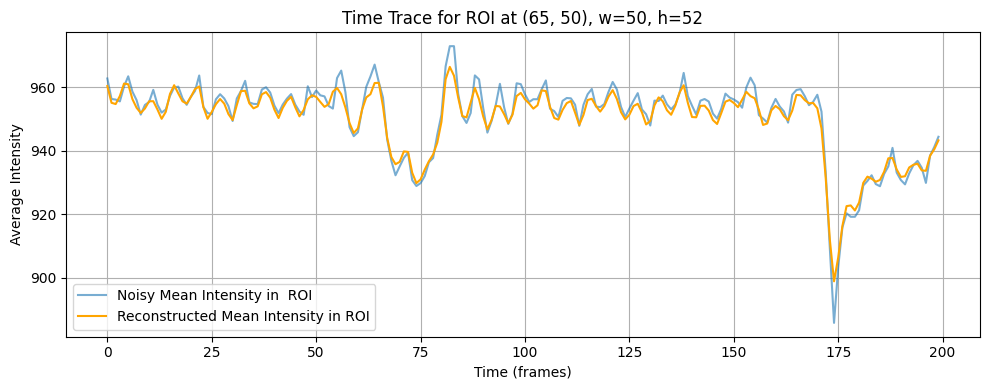

Epoch  410 | loss 5.0266e-02
Epoch  420 | loss 5.0026e-02
Epoch  430 | loss 5.0053e-02
Epoch  440 | loss 5.3074e-02
Epoch  450 | loss 5.3205e-02
Epoch  460 | loss 5.1061e-02
Epoch  470 | loss 5.0192e-02
Epoch  480 | loss 4.9843e-02
Epoch  490 | loss 4.9716e-02


In [1]:
import os
import tifffile
import matplotlib.pyplot as plt
import numpy as np
import torch
from models.skip1d import*
from tqdm.notebook import tqdm
import time
from matplotlib.patches import Rectangle


device = 'cpu'
torch.set_default_dtype(torch.float32)

base_path = "E:\\Voltron2_part1\\Voltron_Cell1"

tif_file = next((f for f in os.listdir(base_path) if f.endswith(".tif")), None)

tif_path = os.path.join(base_path, tif_file)

# Read TIFF file
vol_data = tifffile.imread(tif_path)  # shape: (T, H, W) or (H, W)

# Normalize the full video globally
full_video = torch.tensor(vol_data.astype(np.float32), dtype=torch.float32)
mean_val = full_video.mean()
std_val = full_video.std()

full_video_norm = (full_video - mean_val) / std_val

# Subsample 200 frames
video_tensor = full_video_norm[800:1000]

H, W, T = video_tensor.shape[1], video_tensor.shape[2], video_tensor.shape[0]

video_tensor_flattened = video_tensor.permute(1, 2, 0).reshape(-1, T)  # shape: (H*W, T)


rank_HW = 32
rank_T = 32
epochs = 500
learning_rate = 1e-3

# h_inp = nn.Parameter(torch.randn(1, rank_H, H))
# w_inp = nn.Parameter(torch.randn(1, rank_W, W))
# t_inp = nn.Parameter(torch.randn(1, rank_T, T))

hw_inp = get_1d_posencode_inp(H*W, rank_HW//2)
t_inp = get_1d_posencode_inp(T, rank_T//2)

# Define parameters for skip1d
skip_n33d = 128  # Number of channels in the downsampling path
skip_n33u = 128  # Number of channels in the upsampling path
skip_n11 = 4   # Number of channels in the skip connection
num_scales = 5  # Number of scales in the skip connection
upsample_mode = 'linear'  # Upsampling mode
downsample_mode = 'stride'  # Downsampling mode
pad = 'reflection'  # Padding mode
act_fun = 'LeakyReLU'  # Activation function
filter_size_up=3
filter_size_down=3 
filter_size_skip=1


hw_net = skip1d(
    rank_HW,                       # Dimensionality of positional encoding (e.g., 32)
    rank_HW,                       # Output dimensionality = Tucker rank (e.g., 32)
    num_channels_down = [skip_n33d]*num_scales if isinstance(skip_n33d, int) else skip_n33d,
    num_channels_up   = [skip_n33u]*num_scales if isinstance(skip_n33u, int) else skip_n33u,
    num_channels_skip = [skip_n11]*num_scales if isinstance(skip_n11, int) else skip_n11,
    upsample_mode     = upsample_mode,
    downsample_mode   = downsample_mode,
    need_sigmoid      = False,
    need_bias         = True,
    pad               = pad,
    act_fun           = act_fun,
    filter_size_up    = filter_size_up,
    filter_size_down  = filter_size_down,
    filter_skip_size  = filter_size_skip
)

t_net = skip1d(
    rank_T,                       # Dimensionality of positional encoding (e.g., 32)
    rank_T,                       # Output dimensionality = Tucker rank (e.g., 32)
    num_channels_down = [skip_n33d]*num_scales if isinstance(skip_n33d, int) else skip_n33d,
    num_channels_up   = [skip_n33u]*num_scales if isinstance(skip_n33u, int) else skip_n33u,
    num_channels_skip = [skip_n11]*num_scales if isinstance(skip_n11, int) else skip_n11,
    upsample_mode     = upsample_mode,
    downsample_mode   = downsample_mode,
    need_sigmoid      = False,
    need_bias         = True,
    pad               = pad,
    act_fun           = act_fun,
    filter_size_up    = filter_size_up,
    filter_size_down  = filter_size_down,
    filter_skip_size  = filter_size_skip
)

# Switch to trairning mode
hw_net.train()
t_net.train()

net_params = list(hw_net.parameters()) + list(t_net.parameters())
inp_params = [hw_inp] + [t_inp]
params = net_params + inp_params

criterion_l1 = L2Norm()
    
loss_array = np.zeros(epochs)
mse_array = np.zeros(epochs)    
time_array = np.zeros(epochs)

optimizer = torch.optim.Adam(lr=learning_rate, params=params)
    
# Create a learning scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= epochs)

u_inp_per = hw_inp.detach().clone()
v_inp_per = t_inp.detach().clone()

best_loss = float('inf')
best_epoch = 0
tic = time.time()

tbar = tqdm(range(epochs))

frame_idx = 100  # Example frame index to visualize
x, y = 65, 50      # top-left corner (column, row)
width, height = 50, 52

def plot_frame_with_rectangle(frame, x, y, width, height):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(frame, cmap='hot')
    
    # Add rectangle patch
    rect = Rectangle((x, y), width, height, linewidth=2, edgecolor='b', facecolor='none')
    ax.add_patch(rect)

    ax.set_title(f"Rectangle at ({x}, {y}), w={width}, h={height}")
    plt.grid(False)
    plt.axis('off')
    plt.show()

for idx in tbar:
    A_hw = hw_net(hw_inp).squeeze(0).permute(1, 0)  # [H, 32]
    A_t = t_net(t_inp).squeeze(0).permute(1, 0)  # [T, 32]

    recon = torch.matmul(A_hw, A_t.T)

    loss = criterion_l1(video_tensor_flattened - recon)

    # Track metrics
    loss_array[idx] = loss.item()
    time_array[idx] = time.time() - tic

    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = idx
        best_reconstruction = recon.detach().clone()

    # Backprop
    optimizer.zero_grad()
    torch.autograd.set_detect_anomaly(True)
    loss.backward()
    optimizer.step()
    scheduler.step()  # optional

    # Optionally visualize or print
    if idx % 10 == 0:
        print(f'Epoch {idx:4d} | loss {loss.item():.4e}')
    
    if idx % 100 == 0 or idx == 0:
        recon = recon.reshape(H, W, T).permute(2, 0, 1)
        recon_scaled = recon* std_val + mean_val
        video_scaled = video_tensor * std_val + mean_val
        recon_frame = recon_scaled[frame_idx].detach().cpu().numpy()
        gt_frame = video_scaled[frame_idx].detach().cpu().numpy()

        diff_frame = np.abs(gt_frame - recon_frame)
        diff_frame_signed = gt_frame - recon_frame

        fig, axs = plt.subplots(1, 4, figsize=(12, 4))
        axs[0].imshow(gt_frame, cmap='hot')
        axs[0].set_title('Noisy Input Frame')
        axs[0].axis('off')

        axs[1].imshow(recon_frame, cmap='hot')
        axs[1].set_title('Reconstructed Frame')
        axs[1].axis('off')

        axs[2].imshow(diff_frame, cmap='hot')
        axs[2].set_title('Abs Difference')
        axs[2].axis('off')

        axs[3].imshow(diff_frame_signed, cmap='hot')
        axs[3].set_title('Signed Difference')
        axs[3].axis('off')

        plt.suptitle(f'Epoch {idx}')
        plt.tight_layout()
        plt.show()

        plot_frame_with_rectangle(gt_frame, x, y, width, height)

        # Extract the patch over time (shape: T x height x width)
        patch_noisy = video_scaled[:, y:y+height, x:x+width]  # shape: (T, h, w)
        patch_recon = recon_scaled[:, y:y+height, x:x+width]

        # Average over spatial dimensions
        avg_trace_noisy = patch_noisy.mean(dim=(1, 2)).detach().cpu().numpy()
        avg_trace_recon = patch_recon.mean(dim=(1, 2)).detach().cpu().numpy()

        # Plot the time trace
        plt.figure(figsize=(10, 4))
        plt.plot(avg_trace_noisy, label='Noisy Mean Intensity in  ROI', alpha=0.6)
        plt.plot(avg_trace_recon, label='Reconstructed Mean Intensity in ROI', color='orange')
        plt.xlabel("Time (frames)")
        plt.ylabel("Average Intensity")
        plt.title(f"Time Trace for ROI at ({x}, {y}), w={width}, h={height}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()